# CasADi's Opti Tool

In [1]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import Opti
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.5
Python: 3.12.4


## 1. Regular Springs

### 1.1. Find the equilibrium position of the hanging chain

In [2]:
N = 25  # number of point masses

In [3]:
# Constants
m = 40 / N # mass [kg]
D = 70 * N # spring constant [J/m^2]
g = 9.81 # gravitational constant [m/s^2]
L = 5 / N  # reference length [m]

In [4]:
opti = Opti()

x = opti.variable(N)
y = opti.variable(N)

x.shape, y.shape

((25, 1), (25, 1))

In [5]:
spring_potential = D * cas.sum1(cas.diff(x) ** 2 + cas.diff(y) ** 2) / 2.
gravitional_potential = m * g * cas.sum1(y)
V = spring_potential + gravitional_potential
assert V.shape == (1, 1)

In [6]:
opti.minimize(V)
opti.x.shape

(50, 1)

In [7]:
opti.f.shape

(1, 1)

In [8]:
# Add constraints
opti.subject_to(x[0] == -2)
opti.subject_to(y[0] == 0)
opti.subject_to(x[-1] == 2)
opti.subject_to(y[-1] == 0)
opti.g.shape

(4, 1)

In [9]:
opti.solver('ipopt')
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality c

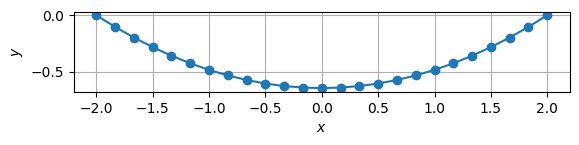

In [10]:
fig, ax = plt.subplots()
ax.plot(sol.value(x), sol.value(y), '-o')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.show()

In [11]:
# Alternative without constraints
opti2 = Opti()

x2 = opti2.variable(N - 2)
y2 = opti2.variable(N - 2)

x2.shape, y2.shape

((23, 1), (23, 1))

In [12]:
spring_potential = D * (
    (x2[0] - -2.) ** 2
    + y2[0] ** 2
    + (x2[-1] - 2.) ** 2
    + y2[-1] ** 2 
    + cas.sum1((x2[1:] - x2[:-1]) ** 2 + (y2[1:] - y2[:-1]) ** 2)
) / 2.
gravitional_potential = m * g * cas.sum1(y2)
V2 = spring_potential + gravitional_potential
assert V2.shape == (1, 1)

In [13]:
opti2.minimize(V2)
opti2.solver('ipopt')
sol2 = opti2.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       90

Total number of variables............................:       46
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0000000e+03 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

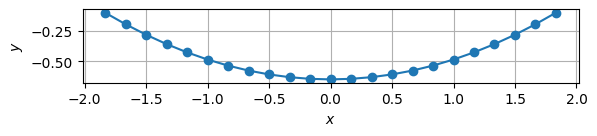

In [14]:
fig, ax = plt.subplots()
ax.plot(sol2.value(x2), sol2.value(y2), '-o')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
plt.show()

In [15]:
assert max(np.abs(np.array(sol.value(x[1:-1])) - np.array(sol2.value(x2)))) < 1e-9
assert max(np.abs(np.array(sol.value(y[1:-1])) - np.array(sol2.value(y2)))) < 1e-8

### 1.2. Inspect the structure of the Hessian

In [16]:
opti.x

MX(vertcat(opti0_x_1, opti0_x_2))

In [17]:
cas.hessian(opti.f, opti.x)[0].sparsity().spy()

**................................................
***...............................................
.***..............................................
..***.............................................
...***............................................
....***...........................................
.....***..........................................
......***.........................................
.......***........................................
........***.......................................
.........***......................................
..........***.....................................
...........***....................................
............***...................................
.............***..................................
..............***.................................
...............***................................
................***...............................
.................***..............................
..................***..........

In [18]:
cas.hessian(opti.f, opti.x)[0].shape

(50, 50)

In [19]:
# There are cross terms between x_i and x_{i-1}
sol.value(cas.hessian(opti.f, opti.x)[0][5:7, 5:7])

array([[ 3500., -1750.],
       [-1750.,  3500.]])

In [20]:
# and between y_i and y_{i-1}
sol.value(cas.hessian(opti.f, opti.x)[0][30:32, 30:32])

array([[ 3500., -1750.],
       [-1750.,  3500.]])

### 1.3. Inspect the value of the Lagrange gradient at the solution

In [21]:
# Lagrange multipliers - shape corresponds to the number of constraints
# because each constraint comes with a multiplier
opti.lam_g.shape

(4, 1)

In [22]:
lag = opti.f + opti.lam_g.T @ opti.g
lag.shape

(1, 1)

In [23]:
grad_lag = sol.value(cas.gradient(lag, opti.x))  # note: this is the Jacobian also
grad_lag

array([ 2.27373675e-13, -3.97903932e-13,  3.97903932e-13, -7.95807864e-13,
        7.95807864e-13,  0.00000000e+00, -3.97903932e-13,  3.97903932e-13,
       -2.27373675e-13, -1.70530257e-13,  2.27373675e-13, -5.68434189e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.70530257e-13,
        1.70530257e-13, -1.70530257e-13,  1.70530257e-13, -1.70530257e-13,
       -3.97903932e-13,  7.95807864e-13, -3.97903932e-13,  0.00000000e+00,
        5.68434189e-14,  0.00000000e+00,  2.84217094e-14, -2.84217094e-14,
        2.84217094e-14, -5.68434189e-14, -8.52651283e-14, -7.10542736e-14,
        2.27373675e-13, -7.10542736e-14,  1.20792265e-13, -7.10542736e-14,
       -7.10542736e-14,  1.24344979e-13, -7.10542736e-14,  1.24344979e-13,
       -6.39488462e-14, -7.81597009e-14,  2.84217094e-14,  2.84217094e-14,
        1.42108547e-14,  4.26325641e-14, -1.42108547e-13,  5.68434189e-14,
        2.84217094e-14, -2.84217094e-14])

This gradient should be close to zero if the solution is good.

In [24]:
np.linalg.norm(grad_lag)

np.float64(1.833083207755712e-12)

### 1.4 Why does the solver need only 1 iteration?

The cost function is a second-order polynomial (i.e. quadratic) function of the states, and the constraints are linear.  A quadratic programming (QP) solver can solve this kind of problem in one iteration.

## 2. Springs with a nonzero rest-length

In [25]:
opti = Opti()

x = opti.variable(N)
y = opti.variable(N)
L = opti.parameter()

$$ D \left( \sqrt{(x_{i+1} - x_{i})^2 + (y_{i+1} - y_{i})^2} - L \right) ^ 2$$

In [26]:
dx_dy_sq = cas.diff(x) ** 2 + cas.diff(y) ** 2
spring_potential = D * cas.sum1(dx_dy_sq - L * cas.sqrt(dx_dy_sq) + L ** 2) / 2.
gravitional_potential = m * g * cas.sum1(y)
V = spring_potential + gravitional_potential
assert V.shape == (1, 1)

In [27]:
opti.minimize(V)
opti.x.shape

(50, 1)

In [28]:
opti.f.shape

(1, 1)

In [29]:
# Add constraints
opti.subject_to(x[0] == -2)
opti.subject_to(y[0] == 0)
opti.subject_to(x[-1] == 2)
opti.subject_to(y[-1] == 0)
opti.g.shape

(4, 1)

In [30]:
opti.set_value(L, 5 / N)

# Need to specify non-zero initial x in this case
opti.set_initial(x, np.linspace(-2, 2, N))
opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      171

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2333333e+02 0.00e+00 1.35e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### 2.2 Why is the Hessian no longer banded?

In [31]:
cas.hessian(opti.f, opti.x)[0].sparsity().spy()

**.......................**.......................
***......................***......................
.***......................***.....................
..***......................***....................
...***......................***...................
....***......................***..................
.....***......................***.................
......***......................***................
.......***......................***...............
........***......................***..............
.........***......................***.............
..........***......................***............
...........***......................***...........
............***......................***..........
.............***......................***.........
..............***......................***........
...............***......................***.......
................***......................***......
.................***......................***.....
..................***..........

Because of the cross terms, $-\frac{DL}{2}\sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2}$, which involve both $y$ and $x$ positions.

We could make the assumption that $y \approx 0$ and that would eliminate these terms (but this would not give an exact solution).  

The better option is to manually re-order the variables, e.g. x1, y1, x2, y2, ... so the structure remains diagonal.

Note that IPOPT will re-order the state variables to produce a more banded structure (as close as possible to the diagonal).  This makes it cheaper to factorize (in terms of memory and computation).

### 2.3 Visualize the intermediate solution for each NLP step

In [32]:
# Introduce a call-back

def plot_iteration(i, x, y):
    ax.plot(sol2.value(x), sol2.value(y), '-o', label=f'i = {i}')

opti.callback(lambda i: plot_iteration(i, opti.debug.value(x), opti.debug.value(y)))

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      171

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.2333333e+02 0.00e+00 1.35e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

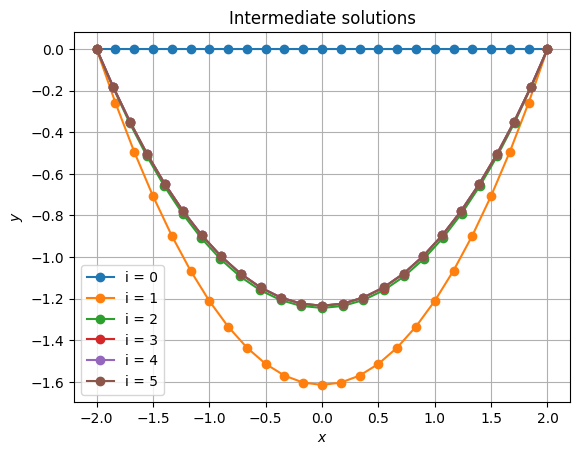

In [33]:
fig, ax = plt.subplots()

opti.set_initial(x, np.linspace(-2, 2, N)); 
opti.solver('ipopt')
sol = opti.solve()

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
ax.legend()
ax.set_title('Intermediate solutions')
plt.show()

For some reason on the solution video, his solver takes 28 steps to converge, unlike 4 here.

## 3. Rigid Bars

### 3.1 Drop the terms for spring potential energy

In [34]:
opti = Opti()

x = opti.variable(N)
y = opti.variable(N)
L = opti.parameter()

In [35]:
# Remove spring potential energy and require fixed distance between masses
dx_dy_sq = cas.diff(x) ** 2 + cas.diff(y) ** 2
assert dx_dy_sq.shape == (N-1, 1)
gravitional_potential = m * g * cas.sum1(y)
V = gravitional_potential
assert V.shape == (1, 1)

opti.minimize(V)
assert opti.x.shape == (N, 1)

# Add boundary constraints
opti.subject_to(x[0] == -2)
opti.subject_to(y[0] == 0)
opti.subject_to(x[-1] == 2)
opti.subject_to(y[-1] == 0)

# Add length constraints
opti.subject_to(dx_dy_sq == L ** 2)

opti.g.shape

(28, 1)

In [36]:
opti.set_value(L, 5 / N)

# Need to specify non-zero initial x in this case
opti.set_initial(x, np.linspace(-2, 2, N))
#opti.set_initial(y, -np.sin(np.linspace(0, np.pi, N)))

opti.solver('ipopt')
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e-02 1.57e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Inspect solution

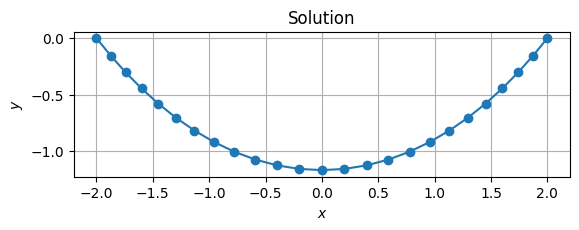

In [37]:
fig, ax = plt.subplots()

ax.plot(sol.value(x), sol.value(y), marker='o')
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
ax.set_title('Solution')
plt.show()

In [38]:
J = cas.jacobian(opti.g, opti.x)
J.shape

(28, 50)

In [39]:
sol.value(J)

DM(sparse: 28-by-50, 100 nnz
 (0, 0) -> 1
 (4, 0) -> -0.252923
 (4, 1) -> 0.252923
 (5, 1) -> -0.266581
 (5, 2) -> 0.266581
 (6, 2) -> -0.281131
 (6, 3) -> 0.281131
 (7, 3) -> -0.296491
 (7, 4) -> 0.296491
 (8, 4) -> -0.312491
 (8, 5) -> 0.312491
 (9, 5) -> -0.328845
 (9, 6) -> 0.328845
 (10, 6) -> -0.345114
 (10, 7) -> 0.345114
 (11, 7) -> -0.360689
 (11, 8) -> 0.360689
 (12, 8) -> -0.374791
 (12, 9) -> 0.374791
 (13, 9) -> -0.386524
 (13, 10) -> 0.386524
 (14, 10) -> -0.394988
 (14, 11) -> 0.394988
 (15, 11) -> -0.399434
 (15, 12) -> 0.399434
 (16, 12) -> -0.399434
 (16, 13) -> 0.399434
 (17, 13) -> -0.394988
 (17, 14) -> 0.394988
 (18, 14) -> -0.386524
 (18, 15) -> 0.386524
 (19, 15) -> -0.374791
 (19, 16) -> 0.374791
 (20, 16) -> -0.360689
 (20, 17) -> 0.360689
 (21, 17) -> -0.345114
 (21, 18) -> 0.345114
 (22, 18) -> -0.328845
 (22, 19) -> 0.328845
 (23, 19) -> -0.312491
 (23, 20) -> 0.312491
 (24, 20) -> -0.296491
 (24, 21) -> 0.296491
 (25, 21) -> -0.281131
 (25, 22) -> 0.281131

In [40]:
# Check rank
rank = np.linalg.matrix_rank(opti.debug.value(J).toarray())
rank

np.int64(28)

In [41]:
assert rank >= J.shape[0]

If the Jacobian is not full rank the optimization will fail.  Often this is due to poor initial conditions.  E.g. here it was necessary to provide a sinusoidal initial condition which is not too far from the final solution.